In [1]:
# === Imports === #
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from captum.attr import IntegratedGradients, NoiseTunnel

In [2]:
# === Dataset === #
class MovieLensDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['userId'].values, dtype=torch.long)
        self.movies = torch.tensor(df['movieId'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

In [3]:
# === Model === #
class RecSys(nn.Module):
    def __init__(self, n_users, n_movies, emb_dim=32):
        super().__init__()
        self.user_emb = nn.Embedding(n_users + 1, emb_dim)
        self.movie_emb = nn.Embedding(n_movies + 1, emb_dim)
        self.fc = nn.Linear(emb_dim * 2, 1)

    def forward(self, user_ids, movie_ids):
        user_emb = self.user_emb(user_ids)
        movie_emb = self.movie_emb(movie_ids)
        x = torch.cat([user_emb, movie_emb], dim=1)
        return self.fc(x).squeeze()

In [4]:
# === Load MovieLens Data === #
df = pd.read_csv("data/ml-latest-small/ratings.csv")
user_map = {u: i for i, u in enumerate(df['userId'].unique())}
movie_map = {m: i for i, m in enumerate(df['movieId'].unique())}
df['userId'] = df['userId'].map(user_map)
df['movieId'] = df['movieId'].map(movie_map)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = MovieLensDataset(train_df)
test_dataset = MovieLensDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [5]:
# === Training === #
n_users = len(user_map)
n_movies = len(movie_map)
model = RecSys(n_users, n_movies)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print("\nTraining the model...")
model.train()
for epoch in range(5):
    total_loss = 0
    for users, movies, ratings in train_loader:
        preds = model(users, movies)
        loss = loss_fn(preds, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}: Loss = {total_loss:.4f}")


Training the model...
Epoch 1: Loss = 3784.8663
Epoch 2: Loss = 916.1094
Epoch 3: Loss = 610.0136
Epoch 4: Loss = 536.2786
Epoch 5: Loss = 501.7871


In [6]:
# === Evaluation === #
model.eval()
with torch.no_grad():
    all_preds, all_targets = [], []
    for users, movies, ratings in test_loader:
        pred = model(users, movies)
        all_preds.extend(pred.numpy())
        all_targets.extend(ratings.numpy())
    mae = np.mean(np.abs(np.array(all_preds) - np.array(all_targets)))
    print(f"\nTest MAE: {mae:.4f}")


Test MAE: 0.7029


In [7]:
# === Captum Attribution === #
print("\nRunning Captum Interpretability...")
ig = IntegratedGradients(lambda x: model.fc(x))
nt = NoiseTunnel(ig)

sample_user_id = test_dataset[0][0].item()
sample_movie_id = test_dataset[0][1].item()
user_embed = model.user_emb(torch.tensor([sample_user_id]))
movie_embed = model.movie_emb(torch.tensor([sample_movie_id]))
input_embed = torch.cat([user_embed, movie_embed], dim=1)
baseline_embed = torch.zeros_like(input_embed)

attr_ig, delta = ig.attribute(input_embed, baselines=baseline_embed, return_convergence_delta=True)
attr_nt = nt.attribute(input_embed, baselines=baseline_embed, nt_samples=10, nt_type='smoothgrad')

user_attr = attr_ig[:, :model.user_emb.embedding_dim].detach().numpy().flatten()
movie_attr = attr_ig[:, model.user_emb.embedding_dim:].detach().numpy().flatten()
smoothed_attr = attr_nt.detach().numpy().flatten()


Running Captum Interpretability...


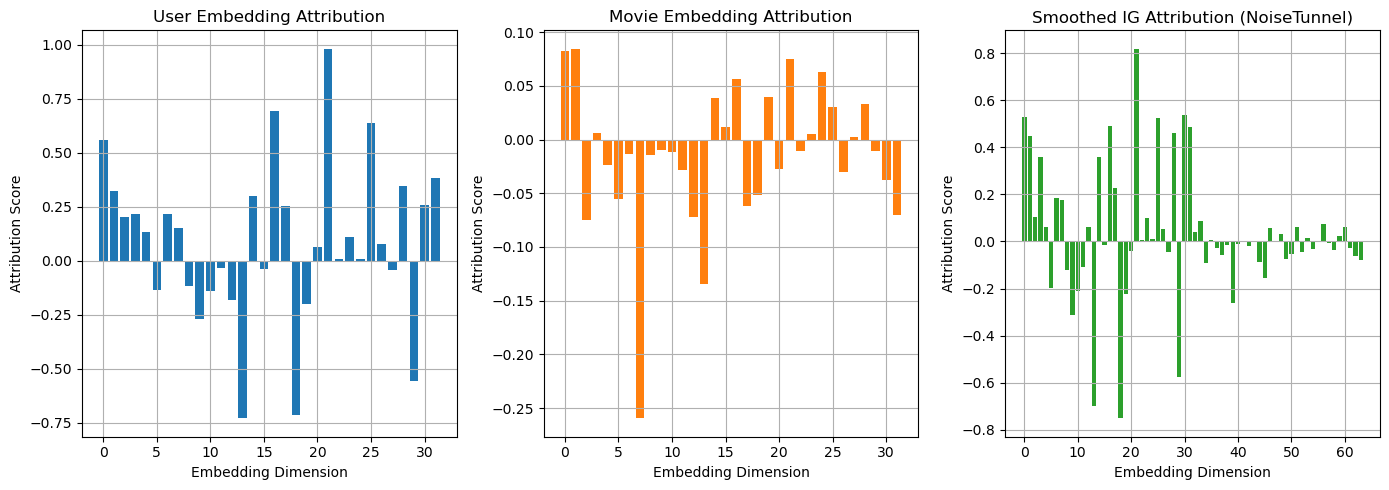


Convergence Delta: -0.000000


In [24]:
# === Visualizations === #
def plot_bar(attr, title, color):
    plt.bar(np.arange(len(attr)), attr, color=color)
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Attribution Score")
    plt.title(title)
    plt.grid(True)

plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plot_bar(user_attr, "User Embedding Attribution", color="tab:blue")
plt.subplot(1, 3, 2)
plot_bar(movie_attr, "Movie Embedding Attribution", color="tab:orange")
plt.subplot(1, 3, 3)
plot_bar(smoothed_attr, "Smoothed IG Attribution (NoiseTunnel)", color="tab:green")
plt.tight_layout()
plt.show()

print(f"\nConvergence Delta: {delta.item():.6f}")

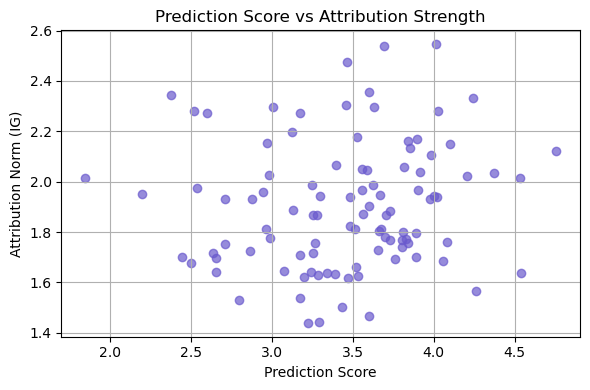

In [25]:
# === Prediction Score vs Attribution Norms === #
def plot_pred_vs_attr_norm(model, dataset, ig):
    attr_norms, preds = [], []
    for i in range(100):
        user, movie, _ = dataset[i]
        u = model.user_emb(user.unsqueeze(0))
        m = model.movie_emb(movie.unsqueeze(0))
        x = torch.cat([u, m], dim=1)
        base = torch.zeros_like(x)
        attr = ig.attribute(x, baselines=base)
        attr_norms.append(torch.norm(attr).item())
        preds.append(model.fc(x).item())

    plt.figure(figsize=(6, 4))
    plt.scatter(preds, attr_norms, alpha=0.7, color='slateblue')
    plt.xlabel("Prediction Score")
    plt.ylabel("Attribution Norm (IG)")
    plt.title("Prediction Score vs Attribution Strength")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pred_vs_attr_norm(model, test_dataset, ig)

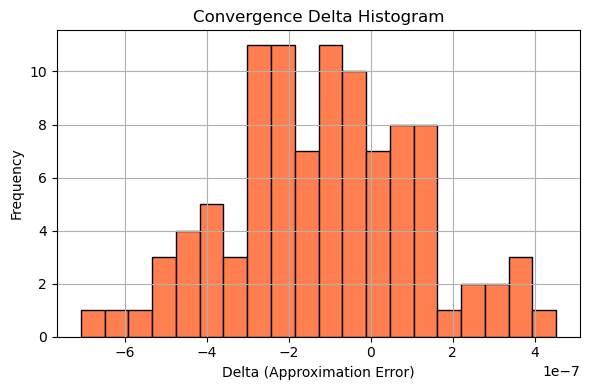

In [26]:
def plot_convergence_deltas(model, dataset, ig):
    deltas = []
    for i in range(100):
        user, movie, _ = dataset[i]
        u = model.user_emb(user.unsqueeze(0))
        m = model.movie_emb(movie.unsqueeze(0))
        x = torch.cat([u, m], dim=1)
        base = torch.zeros_like(x)
        _, delta = ig.attribute(x, baselines=base, return_convergence_delta=True)
        deltas.append(delta.item())

    plt.figure(figsize=(6, 4))
    plt.hist(deltas, bins=20, color="coral", edgecolor="black")
    plt.title("Convergence Delta Histogram")
    plt.xlabel("Delta (Approximation Error)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_convergence_deltas(model, test_dataset, ig)

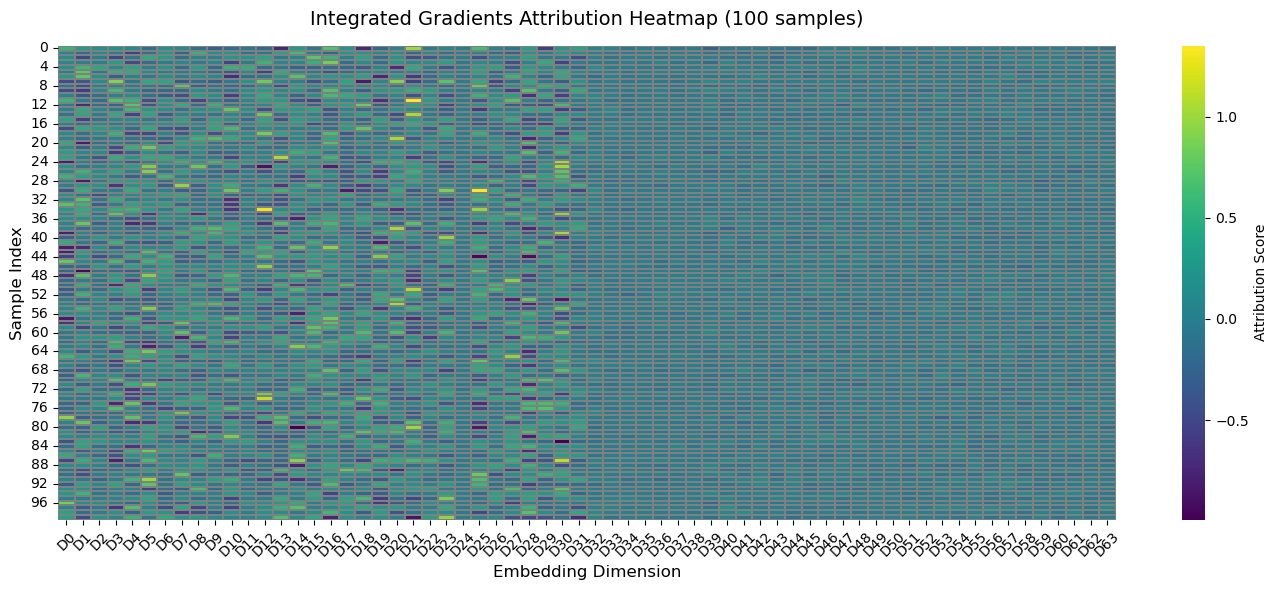

In [28]:
# === Heatmap of IG Attribution Across 100 Samples === #
import seaborn as sns
def generate_ig_heatmap(model, dataset, ig):
    attributions = []
    for i in range(100):
        user, movie, _ = dataset[i]
        u = model.user_emb(user.unsqueeze(0))
        m = model.movie_emb(movie.unsqueeze(0))
        x = torch.cat([u, m], dim=1)
        base = torch.zeros_like(x)
        attr = ig.attribute(x, baselines=base)
        attributions.append(attr.detach().numpy().flatten())

    attributions = np.stack(attributions)
    plt.figure(figsize=(14, 6))
    sns.heatmap(
        attributions,
        xticklabels=[f"D{i}" for i in range(attributions.shape[1])],
        cmap="viridis",
        linewidths=0.3,
        linecolor='gray',
        cbar_kws={'label': 'Attribution Score'}
    )
    plt.title("Integrated Gradients Attribution Heatmap (100 samples)", fontsize=14, pad=15)
    plt.xlabel("Embedding Dimension", fontsize=12)
    plt.ylabel("Sample Index", fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

generate_ig_heatmap(model, test_dataset, ig)